<a href="https://colab.research.google.com/github/ganjire/ML2_Project/blob/main/ML2_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Idea: Automated Disease Detection in Plant Leaves using Convolutional Neural Networks (CNNs)**

**Project Goal/Motivation**

The goal of this project is to develop an automated system that can identify and classify plant diseases from images of plant leaves. This is crucial for agricultural technology as early detection of diseases can lead to timely intervention, reducing both the spread of disease and economic losses. This project will help in understanding the practical application of CNNs in a real-world problem, exploring various architectures, and utilizing transfer learning for effective model performance on a specialized task.

In [61]:
import numpy as np
import pickle
import cv2
from os import listdir
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping





#**Data Collection**

In [2]:
# Download PlantVillage-Dataset from Kaggle
directory_root = drive.mount('/content/drive')
dataset_root = '/content/drive/My Drive/PlantVillage'

Mounted at /content/drive


In [70]:
import os

# Path to your dataset
data_path = '/content/drive/My Drive/PlantVillage'

# List subdirectories to check the structure
os.listdir(data_path)


['Tomato__Target_Spot',
 'Potato___Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Early_blight',
 'Potato___Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Late_blight',
 'Potato___healthy',
 'Pepper__bell___healthy']

In [79]:
import os

data_path = '/content/drive/My Drive/PlantVillage'  # Path to Folder

# Right Path to Main Folder
categories = os.listdir(data_path)
print("Categories (Classes):", categories)

# Optional: Number of Images in Subfolders
for category in categories:
    category_path = os.path.join(data_path, category)
    num_images = len(os.listdir(category_path))
    print(f"{category}: {num_images} images")


Categories (Classes): ['Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato_Early_blight', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Bacterial_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___healthy', 'Pepper__bell___healthy']
Tomato__Target_Spot: 703 images
Potato___Early_blight: 500 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 1605 images
Tomato_healthy: 799 images
Tomato__Tomato_mosaic_virus: 190 images
Tomato_Early_blight: 504 images
Potato___Late_blight: 500 images
Tomato_Leaf_Mold: 481 images
Tomato_Septoria_leaf_spot: 886 images
Tomato_Spider_mites_Two_spotted_spider_mite: 838 images
Tomato_Bacterial_spot: 1069 images
Pepper__bell___Bacterial_spot: 499 images
Tomato_Late_blight: 955 images
Potato___healthy: 76 images
Pepper__bell___healthy: 743 images


In [80]:
from PIL import Image
import numpy as np

def load_images_and_labels(data_directory):
    images = []
    labels = []
    categories = os.listdir(data_directory)

    for label, category in enumerate(categories):
        category_path = os.path.join(data_directory, category)
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img = img.resize((128, 128))
                    img = np.array(img)
                    if img.shape == (128, 128, 3):
                        images.append(img)
                        labels.append(label)
            except Exception as e:
                print(f"Can't load image {image_path}: {e}")

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_path)
print(f"Loaded Images: {len(images)}")
print(f"Loaded Images: {len(labels)}")


Kann das Bild nicht laden /content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Geladene Bilder: 10347
Geladene Labels: 10347


In [82]:
# First Split: Split Training Data (70%) und rest (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels)

# Second Split: Split from Validation Data (20% of 100% -> 2/3 of 30%) and Test Data (10% of 100% -> 1/3 of 30%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)


**Data Augumentation**

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with a validation split and data augmentation options
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of the data for validation
)

# Setup training data generator
train_generator = datagen.flow_from_directory(
    dataset_root,  # Make sure to point to the directory where your images are stored
    target_size=(128, 128),  # Size of output images
    batch_size=64,  # Batch size for training
    class_mode='categorical',  # Type of label arrays to be returned
    subset='training',  # Specify this is training data
    shuffle=True  # It's good practice to shuffle training data
)

# Setup validation data generator
validation_generator = datagen.flow_from_directory(
    dataset_root,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    subset='validation',  # Specify this is validation data
    shuffle=True  # Shuffle validation data to ensure random validation samples
)


Found 8284 images belonging to 15 classes.
Found 2063 images belonging to 15 classes.


In [46]:
import os
import random

# Path to the plant village dataset
dataset_path = '/content/drive/My Drive/PlantVillage'  # Adjust this path to your dataset location

# Iterate through each subfolder in the dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):
        # List all files in the subfolder
        all_files = os.listdir(folder_path)

        # Calculate number of files to delete (half of the total files)
        num_files_to_delete = len(all_files) // 2

        # Randomly select files to delete
        files_to_delete = random.sample(all_files, num_files_to_delete)

        # Delete the selected files
        for file_name in files_to_delete:
            file_path = os.path.join(folder_path, file_name)
            os.remove(file_path)
            print(f'Deleted {file_path}')


Streaming output truncated to the last 5000 lines.
Deleted /content/drive/My Drive/PlantVillage/Tomato_Septoria_leaf_spot/640cbf80-38f9-44e4-a14d-07dcf7effcf2___JR_Sept.L.S 8364.JPG
Deleted /content/drive/My Drive/PlantVillage/Tomato_Septoria_leaf_spot/7d7a2dca-4df0-4aca-9f9b-4894b348bce4___JR_Sept.L.S 8528.JPG
Deleted /content/drive/My Drive/PlantVillage/Tomato_Septoria_leaf_spot/e3c99f3d-4947-41c6-99b1-137fb60195d2___Matt.S_CG 1374.JPG
Deleted /content/drive/My Drive/PlantVillage/Tomato_Septoria_leaf_spot/6d1173c5-9374-46a5-ba0d-e2f72b95e6b2___Matt.S_CG 7851.JPG
Deleted /content/drive/My Drive/PlantVillage/Tomato_Septoria_leaf_spot/ebccf4e1-f615-4812-a572-b3d9adddcf91___Matt.S_CG 7467.JPG
Deleted /content/drive/My Drive/PlantVillage/Tomato_Septoria_leaf_spot/0d12d6ee-bc90-413e-8638-e476cd8ba8ee___Keller.St_CG 1840.JPG
Deleted /content/drive/My Drive/PlantVillage/Tomato_Septoria_leaf_spot/1ab6abd3-f48e-4176-9871-84e611f5b53f___Matt.S_CG 1363.JPG
Deleted /content/drive/My Drive/PlantVi

**Visualization of Augumentation**

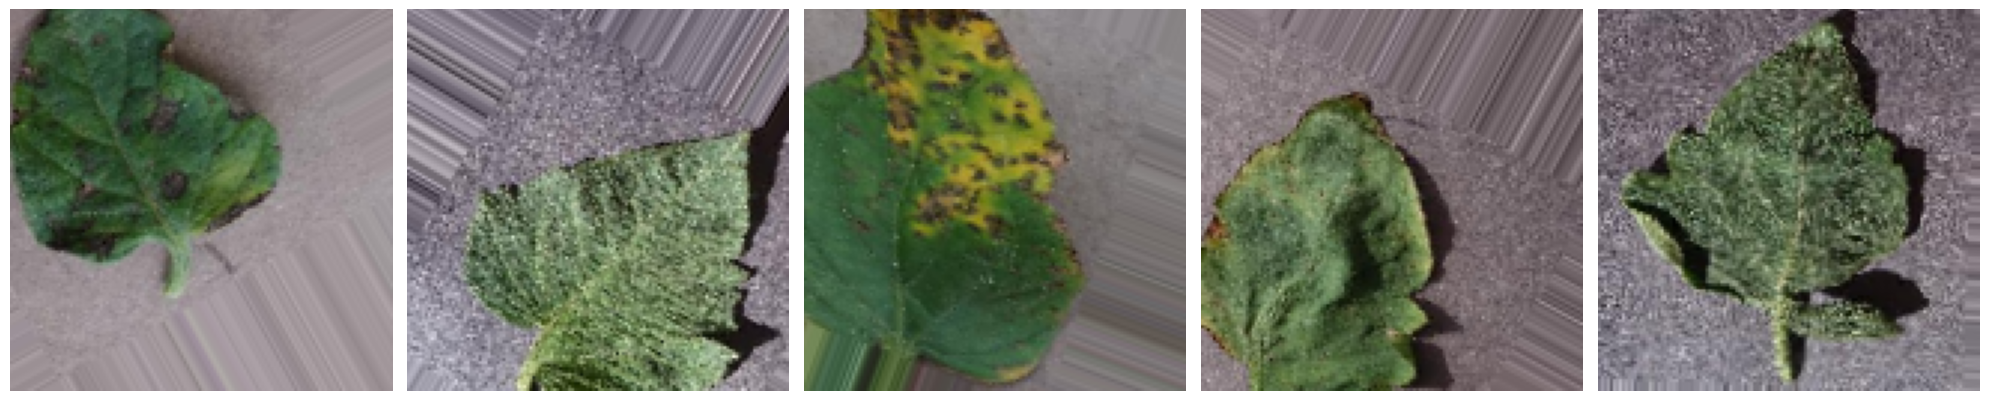

In [51]:
# Display a batch of images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generate a batch of images
images, _ = next(train_generator)
plot_images(images[:5])  # Plot the first 5 images

#**Data Modeling**

**Create 1st Model**





In [52]:
# Define the CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_cnn.summary()




Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 128)     

In [64]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(15, activation='softmax')(x)  # Annahme: 15 Klassen
model = Model(inputs=base_model.input, outputs=predictions)

# Layer des Basis-Modells einfrieren
#for layer in base_model.layers:
    #layer.trainable = False
#maybe löschen
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [66]:
# Fine-tuning: Unfreeze some of the top layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('fine_tuned_mobile_net_v2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
258/258 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.7884

KeyboardInterrupt: 

**2nd Model**

A deeper model with differnet filter sizes and more layers.

In [28]:
model_cnn2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn2.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
model_cnn2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_30 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_32 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 64, 64, 128)       0         
 ng2D)                                                

**Create 3rd Model**

Different activation functions and dropout rates.

In [23]:
model_cnn3 = Sequential([
    Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn3.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
model_cnn3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 